In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import interpolate
from scipy import stats
from scipy import optimize
from scipy import signal
from scipy import fftpack
from statsmodels.nonparametric import smoothers_lowess
from astropy.timeseries import LombScargle
import statistics
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120
% matplotlib notebook



UsageError: Line magic function `%` not found.


In [11]:
def prelim_data(df,select=False):
    # some more cleaning
    df = df.drop('Unnamed: 0', axis=1)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Pram'] = 1.67e-27 * df['np1'] * 100**3 * (df['vp1'] * 1e3)**2
    df['absB'] = (df['Bx']**2 + df['By']**2 + df['Bz']**2)**0.5
    df = df[(df['Pram'] != 0)]
    df['date'] = df['datetime'].dt.date
    df.sort_values('datetime',inplace=True)
    return df

def time_select(df,b,e):
    # select time interval
    # begin = '1977-04-01 00:00:00'
    # end = '1977-04-10 23:59:59'
    begin=b
    end=e
    df_select = df[(df['datetime'] >= begin) & (df['datetime'] <= end)]
    df_select.sort_values('datetime',inplace=True)
    return df_select

def low_pass(timeseries, lowpassvar, f=0.010):
    # datetime_new = pd.array([timeseries['datetime'].iloc[0] + pd.to_timedelta(a, unit='s') for a in t_new])
    Pram_lp = smoothers_lowess.lowess(timeseries[lowpassvar],timeseries['datetime'], is_sorted=True, frac=f, it=0)
    return Pram_lp[:,1]

def datetime_to_seconds(datetime):
    # pandas
    return pd.to_timedelta(datetime - datetime.iloc[0]).dt.total_seconds()

def FT(timeseries,spacing=40.5):
    xf = fftpack.rfftfreq(len(timeseries),d=spacing)
    yf = fftpack.rfft(np.array(timeseries))
    # xf = fftpack.fftshift(xf)
    # yf = fftpack.fftshift(yf)
    return xf, yf

def Lomb_Scargle(timeseries,var):
    return LombScargle(timeseries['datetime'],timeseries[var]).autopower()

def high_freq_change(timeseries, time, d=100):
    grads = abs(np.gradient(timeseries,datetime_to_seconds(time)))
    h = grads.mean() + 2* grads.std()
    peaks, _ = signal.find_peaks(grads,height=h,distance=d)
    return peaks
    
def continuous_periods_with_dist(df):
    # df = df[(df['rh'] < 0.33)]  # If you want to filter based on a condition
    df = df.sort_values('datetime')
    df['time_diff'] = df['datetime'].diff()
    threshold = pd.Timedelta(minutes=15)
    df['group'] = (df['time_diff'] >= threshold).cumsum()

    # dfs = [group_df.drop(['timediff', 'group'], axis=1) for group_df in df.groupby((df['time_diff'] >= threshold).cumsum()) if len(group_df) > 200]
    dfs = []
    for group_df in df.groupby((df['time_diff'] >= threshold).cumsum()):
        if len(group_df[1]) > 200:
            dfs.append(group_df[1])
    return dfs

def CDS(y,x): 
    # x has to be datetime format, x and y have to be in pandas 
    grad = []
    for i in range(len(x)):
        # print(i)
        if i == 0:
            g = (y[i+1]-y[i])/((x.iloc[i+1]-x.iloc[i]).total_seconds())
        else:
            g = (y[i]-y[i-1])/((x.iloc[i]-x.iloc[i-1]).total_seconds())
        # else:
        #     g = (y.iloc[i+1]-y.iloc[i-1])/((x.iloc[i+1]-x.iloc[i-1]).total_seconds())
        grad.append(g)
    return np.array(grad)

def time_variability(actual,var,ratio=False): # find how noisy
    # actual needs to be in pandas dataframe, lowpass is just array
    lowpass = low_pass(timeseries=actual,lowpassvar=var)
    if ratio == False:
        variability = statistics.median(abs((np.array(actual[var]) - np.array(lowpass))))
    else:
        variability = statistics.median(abs((np.array(lowpass) / np.array(actual[var]))))
    return variability

def large_changes_search(actual,var):
    lowpass = abs(CDS(low_pass(timeseries=actual,lowpassvar=var),actual['datetime']))
    threshold = np.mean(lowpass) + 2 * np.std(lowpass)
    lowpass_mask = list(lowpass > threshold)
    big_jump_count = lowpass_mask.count(True)
    return big_jump_count

craft_num = 1
if craft_num == 2:
    year_range = range(1976,1979+1)
else:
    year_range = range(1975,1981+1)

In [12]:
df1 = prelim_data(pd.read_csv(f'mercury_data_1_clean.csv'))
df2 = prelim_data(pd.read_csv(f'mercury_data_2_clean.csv'))

begintime = '1977-04-01 00:00:00'
endtime = '1977-05-10 23:59:59'
df1_select = time_select(df1, begintime, endtime)
df1_select_lp = low_pass(df1_select, 'Pram')


/var/folders/55/hdkytvpd3n971385cnj2p1d40000gn/T/ipykernel_77094/838378011.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select.sort_values('datetime',inplace=True)


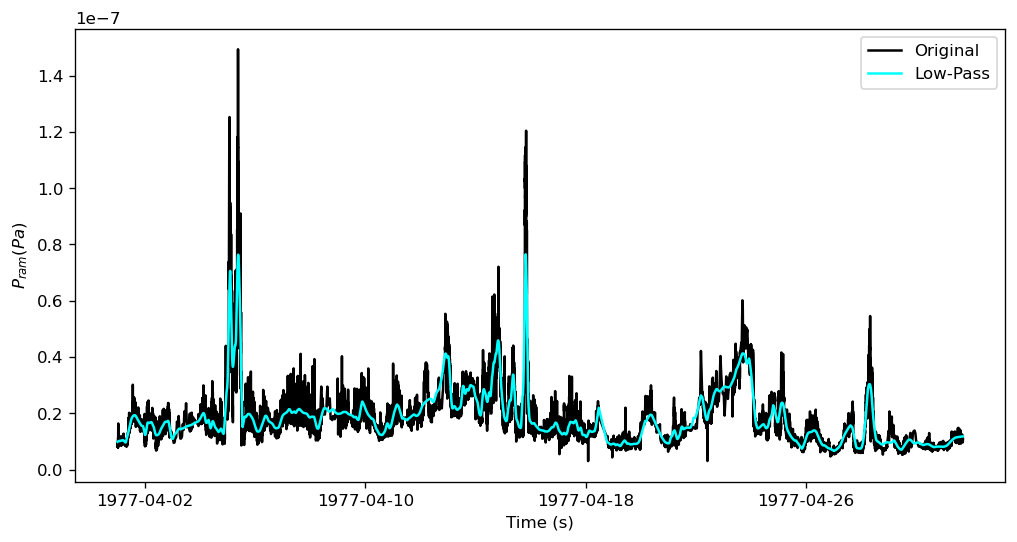

In [13]:
### plot the data and lowpass
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.ylabel(r'$P_{ram} (Pa)$')
plt.xlabel('Time (s)')
plt.plot(df1_select['datetime'],df1_select['Pram'],'-',color='black',label='Original')
plt.plot(df1_select['datetime'],df1_select_lp,'-',color='cyan',label = 'Low-Pass')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.legend()
plt.show()

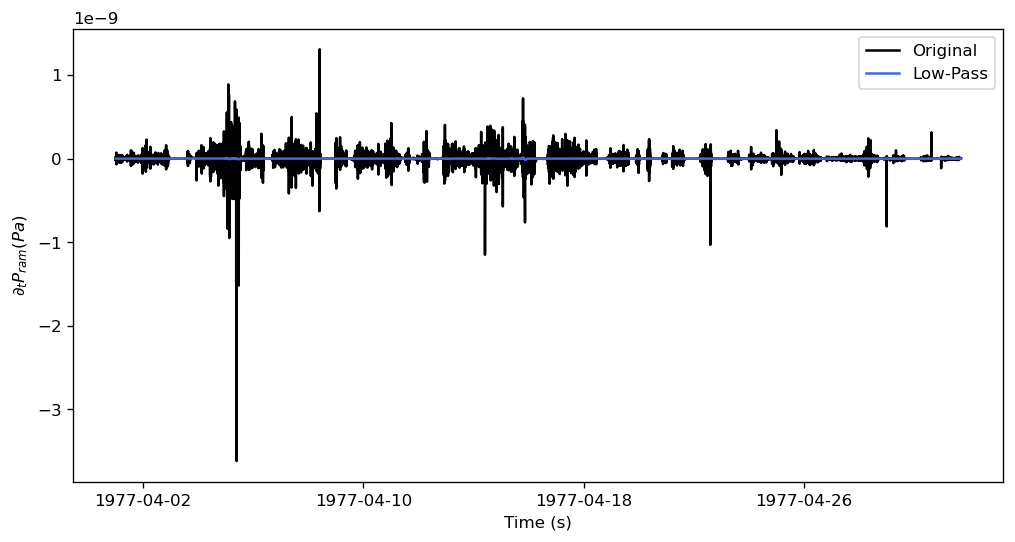

In [14]:
### plot the gradient of the data
df1_grad = CDS(np.array(df1_select['Pram']),df1_select['datetime'])
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.ylabel(r'$\partial_t P_{ram} (Pa)$')
plt.xlabel('Time (s)')
plt.plot(df1_select['datetime'],df1_grad,'-',color='black',label='Original')
plt.plot(df1_select['datetime'],CDS(df1_select_lp,df1_select['datetime']),color='royalblue',label='Low-Pass')
# plt.ticklabel_format(axis='both',style='sci',scilimits=(0,0))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.legend()
plt.show()

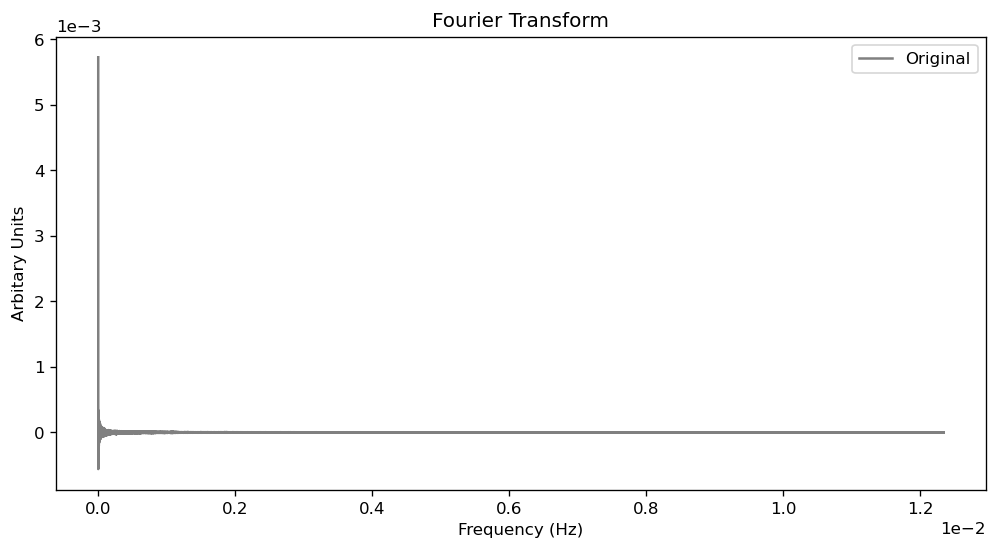

In [15]:
# plot Fourier Transform
ft_df1 = FT(df1['Pram'])
# ft2_df1 = FT_nu(df1_select,'Pram')
ft_df1_peri = FT(df1[(df1['rh'] <= 0.33)&(df1['year'] == 1981)]['Pram'])
ft_df1_aph = FT(df1[(df1['rh'] >= 0.44)&(df1['year'] == 1981)]['Pram'])
plt.figure(figsize=(10,5))
plt.title('Fourier Transform')
plt.ylabel('Arbitary Units')
plt.xlabel('Frequency (Hz)')
# plt.plot(df1_select['datetime'],ft_df1,'-',color='grey',label='Original')
plt.plot(ft_df1[0],ft_df1[1],'-',color='grey',label='Original')
# plt.plot(ft_df1_peri[0],ft_df1_peri[1],'-',color='royalblue',label='Perihelion',alpha=0.7)
# plt.plot(ft_df1_aph[0],ft_df1_aph[1],'-',color='salmon',label='Aphelion',alpha=0.7)
# plt.plot(FT(df1_select_lp)[0],FT(df1_select_lp)[1],'--',color='cyan',label='Low-pass',alpha=0.7)
# plt.vlines(ymin=-1e-3,ymax=1e-3,x=1/86400,linestyles='dashed',colors='red',label='1 day')
# plt.vlines(ymin=-1e-3,ymax=1e-3,x=1/86400/44,linestyles='dashed',colors='green',label='44 day')
plt.ticklabel_format(axis='both',style='sci',scilimits=(0,0))
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

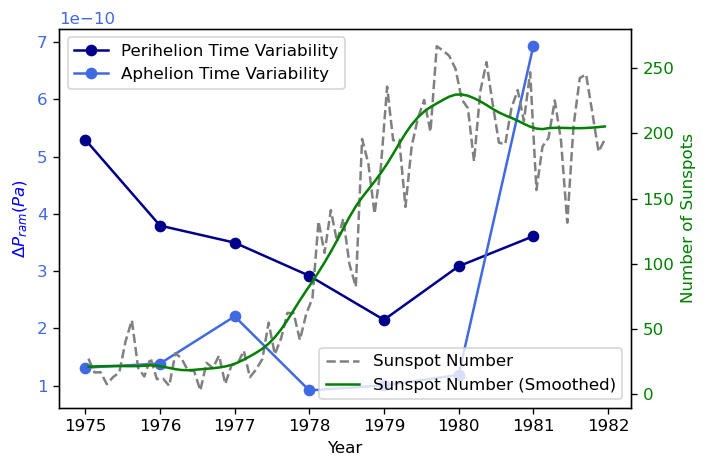

In [16]:
### time variability plot
# df1_goodness = time_variability(df1_select,'Pram')
# print(df1_goodness)
sunspot_data = pd.read_csv('/Users/gordonlai/Documents/ICL/ICL_Y4/MSci_Mercury/msci_mercury_solarwind/SN_m_tot_V2.0.csv',delimiter=';')
sunspot_data.columns = ['year','month','decimaldate','sunspots','others1','others2','others3']
# sunspot_data['datetime'] = pd.to_datetime(sunspot_data['decimaldate'], origin='unix').dt.strftime('%Y%M%D')
# print(sunspot_data)
sunspot_data_x = sunspot_data[(sunspot_data['decimaldate'] >= 1975)&(sunspot_data['decimaldate'] <= 1982)]['decimaldate']
sunspot_data_y = sunspot_data[(sunspot_data['decimaldate'] >= 1975)&(sunspot_data['decimaldate'] <= 1982)]['sunspots']
sunspot_data_y_smooth = smoothers_lowess.lowess(sunspot_data[(sunspot_data['decimaldate'] >= 1975)&(sunspot_data['decimaldate'] <= 1982)]['sunspots'],sunspot_data_x,is_sorted=True, frac=0.250, it=0)[:,1]
continous_df1_1 = continuous_periods_with_dist(df1[(df1['rh'] <= 0.33)])
continous_df1_2 = continuous_periods_with_dist(df1[(df1['rh'] >= 0.44)])

# print(len(continous_df1))
goodnesses_1 = []
for j in year_range:
    good = []
    num_in_year = 0
    for i in range(len(continous_df1_1)):
        if int(pd.to_datetime(continous_df1_1[i]['datetime'].mean()).year) == j:
            good.append(time_variability(continous_df1_1[i],'Pram'))
            num_in_year+=1
    # print(num_in_year)
    goodnesses_1.append(np.mean(good))
goodnesses_2 = []
for j in year_range:
    good = []
    num_in_year = 0
    for i in range(len(continous_df1_2)):
        if int(pd.to_datetime(continous_df1_2[i]['datetime'].mean()).year) == j:
            good.append(time_variability(continous_df1_2[i],'Pram'))
            num_in_year+=1
    # print(num_in_year)
    goodnesses_2.append(np.mean(good))
fig1,ax1 = plt.subplots()
# plt.title('')
ax1.set_xlabel('Year')
ylabel1color = 'royalblue'
ax1.set_ylabel(r'$\Delta P_{ram} (Pa)$',color='blue')
ax1.plot(np.array(year_range),goodnesses_1,'-o',color='darkblue',label='Perihelion Time Variability')
ax1.plot(np.array(year_range),goodnesses_2,'-o',color='royalblue',label='Aphelion Time Variability')
ax1.tick_params(axis='y', labelcolor=ylabel1color)
ax2 = ax1.twinx()
ylabel2color='green'
ax2.set_ylabel('Number of Sunspots',color=ylabel2color)
ax2.plot(sunspot_data_x,sunspot_data_y,'--',color='grey',label='Sunspot Number')
ax2.plot(sunspot_data_x,sunspot_data_y_smooth,'-',color=ylabel2color,label='Sunspot Number (Smoothed)')
ax2.tick_params(axis='y', labelcolor=ylabel2color)
fig1.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.show()